# CHSH-Inequality

#### Uncomment the cell below to pip install the necessary modules if not already installed

#### Note: Works with Qiskit Version 1.4.1 and Quantum Rings Qiskit Toolkit Version 0.1.10

In [1]:
# %pip install numpy
# %pip install qiskit==1.4.1
# %pip install QuantumRingsLib
# %pip install quantumrings-toolkit-qiskit==0.1.10
# %pip install matplotlib
# %pip install pylatexenc

#### Restart the kernel after installing any of the missing packages

### What is the CHSH Inequality?

The CHSH Inequality is used to experimentally prove Bell's Theorem (1969) regarding hidden variables. It was named after the author's Clauser, Horne, Shimoney, and Holt. Bell's Theorem asserts that local hidden variable theories cannot account for some consequences of entanglement in quantum mechanics. The violation of the CHSH Inequality is used to show that quantum mechanics is incompatible with local hidden-variable theories. For reference, the CHSH Inequality is shown below.

$$
|\langle S_1 \rangle| \leq{2}
$$

If we define $S_1$ as 
$$
S_1 = A(B-b) + a(B+b)
$$

Where **A** and **a** represent the bases of the first qubit with **B** and **b** as the bases of the second qubit. $S_1$ represents the measurement of the two qubit system. Each qubit can be found in either the +1 or -1 state. This means that one of the terms must be 0, and the other must be $\pm{2}$. Therefore, $S_1=\pm{2}$ in any given measurement, and the average value shown above must hold true if the local hidden variable theories hold. 

We can define another CHSH quantity $S_2$ in the same way leading to another inequality with a similar result. 

$$
|\langle S_2 \rangle|=|\langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle| \leq{2}
$$

Where we have expanded the average to include the sum of the averages based on the definition of $S_1$ as $S_2$ is defined the same.

In this notebook, you will create an entangled pair between two qubits in a quantum computer by creating the Bell state $\ket{\phi^+} =\frac{\ket{00}+\ket{11}}{2}$. Using the `Estimator` from the Quantum Rings Qiskit Toolkit, we can directly obtain the expectation values needed to calculate the expectation values of the two CHSH quantities as defined above. 

The second qubit is measured in the $Z$ and $X$ bases. The first qubit will be measured in similar orthogonal bases, but with an angle relative to the second qubit. These angles will sweep between 0 and $2\pi$. 

Finally, you will analyze the results and plot them against the measurement angle. For a certain range of measurement angles, the expectation values of CHSH quantities $|\langle S_1 \rangle| > 2$ or $|\langle S_2 \rangle | > 2$, which demonstrates the violation of the CHSH inequality implying that the local hidden variable theories do not hold true.

In [2]:
# Where to find this code?
# https://learning.quantum.ibm.com/tutorial/chsh-inequality

### Step 1: Import required modules

In [3]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# Quantum Rings imports
import QuantumRingsLib
from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2
from quantumrings.toolkit.qiskit import QrEstimatorV2 as Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

### Step 2: Activate your previously saved Quantum Rings Account as the provider and set the backend. Default backend is 'scarlet_quantum_rings'. 

If you have not saved your account locally, please see the documentation on [how to save your account locally](https://portal.quantumrings.com/doc/SavingAccountLocally.html).

In [4]:
provider = QuantumRingsProvider()
backend = QrBackendV2(provider, num_qubits=2)

backend.name

'scarlet_quantum_rings'

### Step 3: Create a parameterized CHSH Circuit. 
The circuit itself consists of a Hadamard gate applied to qubit 1 putting it in a superposition state. A Controlled-NOT (or Controlled-X) gate is then applied with qubit 1 as the control and qubit 2 as the target. In the circuit these will show up as $q_0$ and $q_1$ respectively. Following the control gate, a rotation about the y-axis is performed via a $R_y$ gate based on some parameter $\theta$ theta that will be given values later.

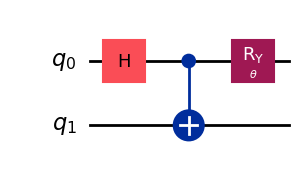

In [5]:
theta = Parameter("$\\theta$")

chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
chsh_circuit.ry(theta, 0)
chsh_circuit.draw(output="mpl", idle_wires=False, style="iqp")

### Step 4: Create a range of theta values from 0 to $2\pi$
Here we create 21 phase angle values with equal spacing such that the values are $0$, $0.1\pi$, $0.2\pi$, ..., $1.9\pi$, $2\pi$. 

Following this you will create observables from which to compute the expectation values. Since you are using the parameterized Y-rotation for the first qubit sweep across the measurement basis with respect to the second qubit basis you only have two other bases you can choose. You want to look at orthogonal bases so your choices for the observables are ZZ, ZX, XZ, and XX. 

#### Exercise: What happens if we change the rotation gate to Z or X and then use YX in the case of Z or YZ in the case of X as our bases?

In [6]:
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)

# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

In [7]:
# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
observable1 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])

# <CHSH2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
observable2 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)])

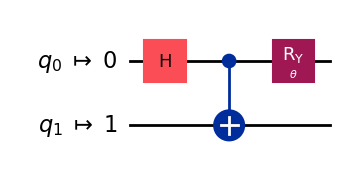

In [8]:
# This cell transpiles the circuit into a readable Instruction Set Architecture (ISA) that is 
# recognized by qiskit. This is based on the Estimator V2 primitive that is used.

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

chsh_isa_circuit = pm.run(chsh_circuit)
chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")

In [9]:
# Here we do the same conversion to an ISA for the observables to be compatible with the Estimator

isa_observable1 = observable1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=chsh_isa_circuit.layout)

In [10]:
# Create a Qiskit Runtime Estimator primitive to compute the expectation values

estimator = Estimator(backend=backend)

# The primitive unified blocs (PUBs) are an iterable for the estimator with the format
# (circuit, observables, parameter_values: Optional, precision: Optional) 
# Here we exclude precision
pub = (
    chsh_isa_circuit,  # ISA circuit
    [[isa_observable1], [isa_observable2]],  # ISA Observables
    individual_phases,  # Parameter values
)

job_result = estimator.run(pubs=[pub]).result()

### Step 5: Return result in classical format and process
The cell below stores the data from the `job_result` ran above for both observables. The first observable is the sum of the expectation values for $\langle ZZ \rangle - \langle ZX \rangle + \langle XZ \rangle + \langle XX \rangle$ and the second observable $\langle ZZ \rangle + \langle ZX \rangle - \langle XZ \rangle + \langle XX \rangle$. These are the estimated values based on everything you have defined above. The cell following plots these results.

In [11]:
chsh1_est = job_result[0].data.evs[0]
chsh2_est = job_result[0].data.evs[1]

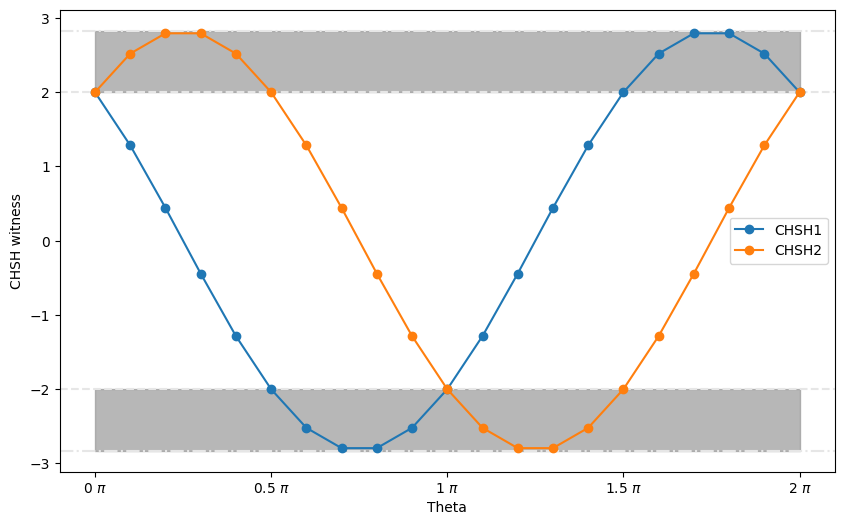

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

### Conclusion

Congratulations! You have tested the CHSH Inequality! Based on the plot above, the gray bars shown represent the areas that fall outside of the CHSH inequality where the magnitude of the observables are greater than 2. Since this occurs, we can claim that the local hidden variable theorems are in fact false. By creating and executing this quantum circuit, you have successfully demonstrated the violation of the CHSH inequality in a quantum system!